### Import Libraries

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import classification_report

In [3]:
dirs = ['with_mask', 'without_mask']

### Load images from the 2 classes and also its corresponding labels

In [4]:
data = []
labels = []

for dir in dirs:
    path = os.path.join('mask_data', dir)
    
    # Iterate over all images in each class
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        
        # load and resize image
        image = load_img(img_path, target_size=(224, 224))
        
        # convert image into array
        image = img_to_array(image)
        
        # Preprocess image to meet the format of the model (MobileNet)
        image = preprocess_input(image)
        
        # Store image and label into a list
        data.append(image)
        labels.append(dir)

C:\Users\DAVE\Anaconda3\envs\ComputerVision\lib\site-packages\PIL\Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


### Visualize the distribution of the data

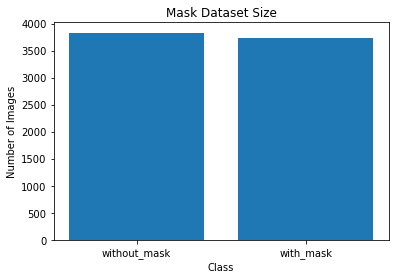

In [5]:
x = pd.Series(labels).value_counts()

plt.bar(x.index, x)
plt.title('Mask Dataset Size')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

### Encode the labels

In [6]:
# Transforming labels into categorical values
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

### Convert data and labels from list to a numpy array

In [7]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

### Split dataset into 80% Training and 20% Testing

In [8]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=40)

### Define Hyperparameters

In [9]:
lr = 1e-4
epochs = 20
batch_size = 32

### Create the Image Data Generator for Data Augmentation

In [10]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

### Build the base model (MobileNet)

In [11]:
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

### Build the head model

In [12]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7,7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# Connect the head model and the base model
model = Model(inputs=baseModel.input, outputs=headModel)

### Freeze layers in the base model

In [13]:
for layer in baseModel.layers:
    layer.trainable = False

### Create the optimizer

In [14]:
opt = Adam(lr=lr, decay=lr/epochs)

### Compile the Model

In [15]:
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=['accuracy'])

### Fitting the training dataset into the constructed model

In [16]:
H = model.fit(
    aug.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch = len(x_train)//batch_size,
    validation_data=(x_test, y_test),
    validation_steps=len(x_test)//batch_size,
    epochs=epochs
)

Epoch 1/20
188/188 [==============================] - 226s 1s/step - loss: 0.2474 - accuracy: 0.8987 - val_loss: 0.0578 - val_accuracy: 0.9835
Epoch 2/20
188/188 [==============================] - 271s 1s/step - loss: 0.0791 - accuracy: 0.9744 - val_loss: 0.0452 - val_accuracy: 0.9848
Epoch 3/20
188/188 [==============================] - 291s 2s/step - loss: 0.0637 - accuracy: 0.9800 - val_loss: 0.0394 - val_accuracy: 0.9848
Epoch 4/20
188/188 [==============================] - 286s 2s/step - loss: 0.0552 - accuracy: 0.9809 - val_loss: 0.0344 - val_accuracy: 0.9881
Epoch 5/20
188/188 [==============================] - 248s 1s/step - loss: 0.0421 - accuracy: 0.9867 - val_loss: 0.0398 - val_accuracy: 0.9861
Epoch 6/20
188/188 [==============================] - 249s 1s/step - loss: 0.0389 - accuracy: 0.9857 - val_loss: 0.0321 - val_accuracy: 0.9887
Epoch 7/20
188/188 [==============================] - 251s 1s/step - loss: 0.0402 - accuracy: 0.9867 - val_loss: 0.0327 - val_accuracy: 0.9887

188/188 [==============================] - 242s 1s/step - loss: 0.0251 - accuracy: 0.9913 - val_loss: 0.0273 - val_accuracy: 0.9921
Epoch 18/20
188/188 [==============================] - 267s 1s/step - loss: 0.0296 - accuracy: 0.9899 - val_loss: 0.0330 - val_accuracy: 0.9894
Epoch 19/20
188/188 [==============================] - 251s 1s/step - loss: 0.0209 - accuracy: 0.9935 - val_loss: 0.0251 - val_accuracy: 0.9927
Epoch 20/20
188/188 [==============================] - 212s 1s/step - loss: 0.0225 - accuracy: 0.9930 - val_loss: 0.0267 - val_accuracy: 0.9927


### Use the trained model to predict the testing dataset

In [17]:
predIdxs = model.predict(x_test, batch_size=batch_size)

# Since result is in probability, therefore we take the index of the max out of the 2
predIdxs = np.argmax(predIdxs, axis=1)

### Print the classification report

In [18]:
print(classification_report(np.argmax(y_test, axis=1), predIdxs))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       745
           1       1.00      0.99      0.99       766

    accuracy                           0.99      1511
   macro avg       0.99      0.99      0.99      1511
weighted avg       0.99      0.99      0.99      1511



### Save model

In [19]:
model.save('mask_detector', save_format="h5")

### Visualize training loss and accuracy

<Figure size 1584x1152 with 0 Axes>

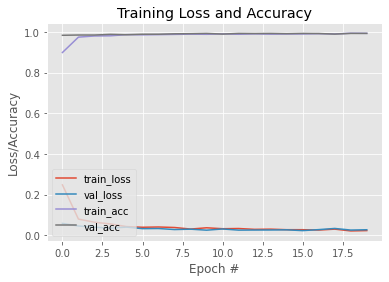

In [21]:
N = epochs
plt.figure(figsize=(22,16))
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

plt.show()

### Load the trained model

In [22]:
model = load_model("mask_detector")

### Get time needed to predict 1 image in microseconds

In [23]:
import time
import datetime

t0 = datetime.datetime.now()
predIdxs = model.predict(np.array([x_test[-1]], dtype="float32"), batch_size = 32)

print((datetime.datetime.now() - t0).microseconds)

674643
